## kerasとsequnece to sequence

前回、LSTMによる実装を行いましたので、次はsquence to sequenceモデルを実装していこうと思います。今現在では、機械翻訳などの自然言語処理では、このsequnece to sequenceとAttentionを基本としたモデルがよく利用されています。BERTなどもAttentionモデルが基本となっています。

ここでは、復習もかねて、基本的なsequnece to sequenceを実装します。$y=\sin x$を$y=\cos x$に翻訳するモデルの構築を行います。なお、モデルの詳細は検索すればいくらでも出てきますのでここでは割愛します。文献や教科書、技術者によっては、sequnece to sequenceモデルは、「Encoder-Decoderモデル」、「系列変換モデル」などと呼ばれることも多いようです。

以下ではkerasを用いてseq2seqの実装を行いますが、詳細は[公式ブログ](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)を参照してください。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/tree/master/ml/lec/text/seq2seq/seq2seq_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/tree/master/ml/lec/text/seq2seq/seq2seq_nb.ipynb)

### 筆者の環境
筆者のOSはmacOSです。LinuxやUnixのコマンドとはオプションが異なります。

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G6020


In [2]:
!python -V

Python 3.7.3


基本的なライブラリとkerasをインポートしそのバージョンを確認しておきます。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np

import tensorflow as tf
from tensorflow import keras
import gensim

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('tensorflow version : ', tf.__version__)
print('keras version : ', keras.__version__)
print('gensim version : ', gensim.__version__)

matplotlib version : 3.0.3
scipy version : 1.4.1
numpy version : 1.19.4
tensorflow version :  2.4.0
keras version :  2.4.0
gensim version :  3.8.3


## sequence to sequence モデルの入出力データ

最初にsequence to sequence モデルのアルゴリズムの概要と、それをkerasで実行する場合、どのようなデータの入出力になるのかを簡単に説明しようと思います。

### データの入出力のイメージ

![svg](seq2seq_nb_files_local/seq2seq.svg)

sequence to sequence はencoderとdecoderという二つの部分で構成されています。それぞれの部分はRNNやLSTMなどのモデルで構築されます。
このような特徴から時系列データの解析に強く、機械翻訳や音声認識などの分野で利用されているようです。

kerasでseq2seqを実装するには、encoderとdecoderそれぞれへの入力データ（図で言うdataset 1と2）と正解データ（dataset 3)が必要になります。

正解データは、decoderへの入力セットから時系列的に一つずれていることがポイントになります。

以下のサイトを参考にさせていただきました。

- https://blog.octopt.com/sequence-to-sequence/



## サンプルデータ

サンプル用のエンコーダーデータ、デコーダーデータとして、以下の式を利用します。

$$
\text{encoder} : y = \sin{x} 
$$

$$
\text{dencoder} : y = \cos x
$$

サイン関数をコサイン関数に変換します。

In [4]:
## seq2seq sin cos
x = np.linspace(-2*np.pi, 2*np.pi, 100)  # -2πから2πまで
seq_in = np.sin(x)
seq_out = np.cos(x)

### データの確認

$x$と$y$のデータの詳細を見てみます。

In [5]:
print('shape : ', x.shape)
print('ndim : ', x.ndim)
print('data : ', x[:10])

shape :  (100,)
ndim :  1
data :  [-6.28318531 -6.15625227 -6.02931923 -5.9023862  -5.77545316 -5.64852012
 -5.52158709 -5.39465405 -5.26772102 -5.14078798]


In [6]:
print('shape : ', seq_in.shape)
print('ndim : ', seq_in.ndim)
print('data : ', seq_in[:10])

shape :  (100,)
ndim :  1
data :  [2.44929360e-16 1.26592454e-01 2.51147987e-01 3.71662456e-01
 4.86196736e-01 5.92907929e-01 6.90079011e-01 7.76146464e-01
 8.49725430e-01 9.09631995e-01]


In [7]:
print('shape : ', seq_out.shape)
print('ndim : ', seq_out.ndim)
print('data : ', seq_out[:10])

shape :  (100,)
ndim :  1
data :  [1.         0.99195481 0.9679487  0.92836793 0.87384938 0.80527026
 0.72373404 0.63055267 0.52722547 0.41541501]


グラフを確認してみます。

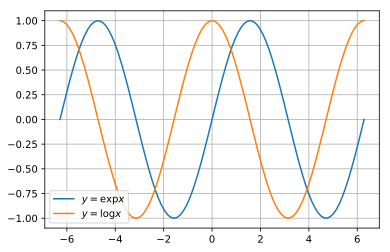

In [8]:
plt.plot(x, seq_in, label='$y=\exp x$')
plt.plot(x, seq_out, label='$y=\log x$')
plt.legend()
plt.grid()
plt.show()

### データとパラメタの準備

学習に利用するハイパーパラメタの値を設定します。

In [9]:
# LSTMネットワークのパラメタ
NUM_LSTM = 24
NUM_MID = 75

# 学習用のパラメタ
batch_size = 10
epochs = 35

kerasに入力するためのデータをnumpy配列に格納します。

In [10]:
n = len(x) - NUM_LSTM
ex = np.zeros((n, NUM_LSTM))
dx = np.zeros((n, NUM_LSTM))
dy = np.zeros((n, NUM_LSTM))

for i in range(0, n):
  ex[i] = seq_in[i : i + NUM_LSTM]
  dx[i, 1: ] = seq_out[i: i + NUM_LSTM-1]
  dy[i] = seq_out[i: i + NUM_LSTM]

ex = ex.reshape(n, NUM_LSTM, 1)
dx = dx.reshape(n, NUM_LSTM, 1)
dy = dy.reshape(n, NUM_LSTM, 1)

## モデルの構築

sequence to sequenceのモデルをkerasを用いて実装します。
単純なRNNやLSTMとは異なり、モデルが複数あり、それぞれから入力する必要があるため、Sequenceではなく、Modelを利用します。

詳細はkerasの[公式ブログ](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)を参照にしてください。

In [11]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

e_input = Input(shape=(NUM_LSTM, 1))
e_lstm = LSTM(NUM_MID, return_state=True)
e_output, e_state_h, e_state_c = e_lstm(e_input)

# decoeder側に隠れ層とセルの状態を受け渡す必要があるので、リストを作成
e_state = [e_state_h, e_state_c]

d_input = Input(shape=(NUM_LSTM, 1))
d_lstm = LSTM(NUM_MID, return_sequences=True, return_state=True)
d_output, _, _ = d_lstm(d_input, initial_state=e_state)
d_dense = Dense(1, activation='linear')
d_output = d_dense(d_output)

seq2seq_model = Model([e_input, d_input], d_output)

# 最適化のモデルと損失関数の定義=>どちらでも大きな変化なし
seq2seq_model.compile(optimizer="adam", loss="mean_squared_error")
# seq2seq_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# モデルの確認
print(seq2seq_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 75), (None,  23100       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 24, 75), (No 23100       input_2[0][0]                    
                                                                 lstm[0][1]                   

## モデルの学習

In [12]:
history = seq2seq_model.fit([ex, dx], dy, epochs=epochs, batch_size=batch_size, verbose=False)

## 損失関数

損失関数が減少していく様子を可視化してみます。

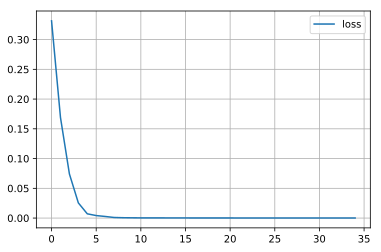

In [13]:
loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss, label='loss')
plt.grid()
plt.legend()
plt.show()

十分に収束してる事が分かります。

## 予測するためのencoderとdecoderのモデルを返す関数の作成

### 予測用のencoderモデルの構築

インプットするインスタンスや隠れ層やセルの状態は訓練済みのものを利用します。

In [14]:
pred_e_model = Model(e_input, e_state)

### 予測用のdecoderモデルの構築

In [15]:
# decoderのモデルを構築
pred_d_input = Input(shape=(1, 1))

pred_d_state_in_h = Input(shape=(NUM_MID,))
pred_d_state_in_c = Input(shape=(NUM_MID,))
pred_d_state_in = [pred_d_state_in_h, pred_d_state_in_c]

# 学習の時に利用したLSTMを利用
pred_d_output, pred_d_state_h, pred_d_state_c = d_lstm(pred_d_input, initial_state=pred_d_state_in)
pred_d_state = [pred_d_state_h, pred_d_state_c]

# 学習の時に利用したDENSE層を利用
pred_d_output = d_dense(pred_d_output)
pred_d_model = Model([pred_d_input] + pred_d_state_in, [pred_d_output] + pred_d_state)

## 予測用関数の定義

インプットデータを受け取り、それをdecoderで変換して、結果を出力する関数を構築します。

In [16]:
def get_output_data(input_data):
  state_value = pred_e_model.predict(input_data)
  _dy = np.zeros((1, 1, 1))
  
  output_data = []
  for i in range(0, NUM_LSTM):
    y_output, y_state_h, y_state_c = pred_d_model.predict([_dy] + state_value)
    
    output_data.append(y_output[0, 0, 0])
    dy[0, 0, 0] = y_output
    state_value = [y_state_h, y_state_c]

  return output_data

## 結果の確認


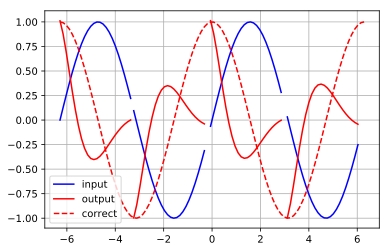

In [17]:
init_points = [0, 24, 49, 74]

for i in init_points:
  _x = ex[i : i + 1]
  _y = get_output_data(_x)
    
  if i == 0:
    plt.plot(x[i : i + NUM_LSTM], _x.reshape(-1), color="b", label='input')
    plt.plot(x[i : i + NUM_LSTM], _y, color="r", label='output')
  else:
    plt.plot(x[i : i + NUM_LSTM], _x.reshape(-1), color="b")
    plt.plot(x[i : i + NUM_LSTM], _y, color="r")
  
plt.plot(x, seq_out, color = 'r', linestyle = "dashed", label = 'correct')
plt.grid()
plt.legend()
plt.show()  

何となく形状は捉えているような感じがしますが、どうでしょうか？もう少し、突き詰めれば良い変換が出来そうですが、今回はデモなので子ここまでにしておきます。

## 様々なseq2seq

最後のコードを関数化し、様々なインプットに対して、アウトプットがどうなるか見てみます。

In [18]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model


def main(x, seq_in, seq_out):

  n = len(x) - NUM_LSTM
  ex = np.zeros((n, NUM_LSTM))
  dx = np.zeros((n, NUM_LSTM))
  dy = np.zeros((n, NUM_LSTM))

  for i in range(0, n):
    ex[i] = seq_in[i : i + NUM_LSTM]
    dx[i, 1: ] = seq_out[i: i + NUM_LSTM-1]
    dy[i] = seq_out[i: i + NUM_LSTM]

  ex = ex.reshape(n, NUM_LSTM, 1)
  dx = dx.reshape(n, NUM_LSTM, 1)
  dy = dy.reshape(n, NUM_LSTM, 1)
  
  e_input = Input(shape=(NUM_LSTM, 1))
  e_lstm = LSTM(NUM_MID, return_state=True)
  e_output, e_state_h, e_state_c = e_lstm(e_input)
    
  # encoder stateのリスト化
  e_state = [e_state_h, e_state_c]
  
  d_input = Input(shape=(NUM_LSTM, 1))
  d_lstm = LSTM(NUM_MID, return_sequences=True, return_state=True)
  d_output, _, _ = d_lstm(d_input, initial_state=e_state)
  d_dense = Dense(1, activation='linear')
  d_output = d_dense(d_output)
  
  seq2seq_model = Model([e_input, d_input], d_output)
  seq2seq_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
  
  ## 予測
  history = seq2seq_model.fit([ex, dx], dy, epochs=epochs, batch_size=batch_size, verbose=False)
  
  ## 結果確認
  init_points = [0, 24, 49, 74]
  
  for i in init_points:
    _x = ex[i : i + 1]
    _y = get_output_data(_x)
      
    if i == 0:
      plt.plot(x[i : i + NUM_LSTM], _x.reshape(-1), color="b", label='input')
      plt.plot(x[i : i + NUM_LSTM], _y, color="r", label='output')
    else:
      plt.plot(x[i : i + NUM_LSTM], _x.reshape(-1), color="b")
      plt.plot(x[i : i + NUM_LSTM], _y, color="r")
    
  plt.plot(x, seq_out, color = 'r', linestyle = "dashed", label = 'correct')
  plt.grid()
  plt.legend()
  plt.show()  

## seq2seq exp to log

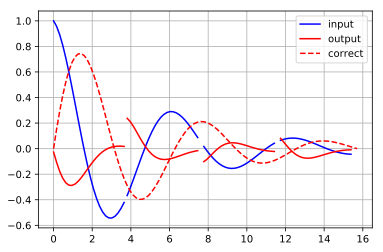

In [19]:
x = np.linspace(0, 5 * np.pi, 100)
seq_in = np.exp(-x / 5) * (np.cos(x))
seq_out = np.exp(-x / 5) * (np.sin(x))

main(x, seq_in, seq_out)

## seq2seq 0.5乗 to 2乗

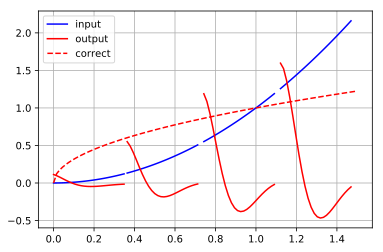

In [20]:
x = np.linspace(0, 1.5, 100)
seq_out = np.array(x ** 0.5)
seq_in = np.array(x ** 2)

main(x, seq_in, seq_out)

三角関数以外は、もう少しモデルを最適化しないと実用上使えない（特に減衰振動曲線の場合は、位相が180度ずれているのが致命的）と思います。
今回はkerasのseq2seqに慣れる練習なので、ここまでにしておきます。

しつこいですが、詳細は[公式ブログ](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)を参考にしてください。